In [1]:
import torch
import pickle
import numpy as np
from evaluation import *
from functions import *
from Models.UNet import *
from torch.utils.data import TensorDataset
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Loading dataset
x = pickle.load(open("./Xs.pkl", "rb"))
y = pickle.load(open("./Ys.pkl", "rb"))

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
x = torch.FloatTensor(x)
y = torch.FloatTensor(y)

In [4]:
# Shifting dimensions
x, y = x.permute(0, 3, 1, 2), y.permute(0, 3, 1, 2)
# Removing channel 1 in input channels
x = torch.cat((x[:, 0:1, :, :], x[:, 2:, :, :]), dim=1)
# Adding binary channel to describe the shape of object
bin_channel = torch.isnan(x[:, 2:, :, :]).type(torch.float)
x = bin_channel
print(torch.sum(bin_channel))

tensor(467592.)


In [5]:
# Removing NaN values
x[torch.isnan(x)] = 0
y[torch.isnan(y)] = 0

In [6]:
# Computing Root Mean Square of features to equally prioritize each feature in loss function
features_mse = torch.sqrt(torch.mean(y.permute(0, 2, 3, 1).view(-1, y.shape[1]) ** 2, dim=0)).view(1, -1, 1, 1).to(device)
print(features_mse)

tensor([[[[0.1156]],

         [[0.0173]],

         [[0.0135]]]], device='cuda:0')


In [7]:
print(x.shape)
print(y.shape)

torch.Size([961, 1, 172, 79])
torch.Size([961, 3, 172, 79])


In [8]:
# Shuffling the dataset
x, y = shuffle_tensors(x, y)

In [9]:
# Spliting dataset into 70% train and 30% test
train_data, test_data = split_tensors(x, y, ratio=0.7)
train_dataset, test_dataset = TensorDataset(*train_data), TensorDataset(*test_data)

In [10]:
# Creating model
model = UNet(1, 3, filters=[16,32,8], kernel_size=7, layers=3,
                    batch_norm=False, weight_norm=False)
model

UNet(
  (encoder): Sequential(
    (0): Sequential(
      (0): Sequential(
        (0): Conv2d(1, 16, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
        (1): ReLU()
      )
      (1): Sequential(
        (0): Conv2d(16, 16, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
        (1): ReLU()
      )
      (2): Sequential(
        (0): Conv2d(16, 16, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
        (1): ReLU()
      )
    )
    (1): Sequential(
      (0): Sequential(
        (0): Conv2d(16, 32, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
        (1): ReLU()
      )
      (1): Sequential(
        (0): Conv2d(32, 32, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
        (1): ReLU()
      )
      (2): Sequential(
        (0): Conv2d(32, 32, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
        (1): ReLU()
      )
    )
    (2): Sequential(
      (0): Sequential(
        (0): Conv2d(32, 8, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
        (1): R

In [11]:
# Initializing weights
# initialize(model)

In [12]:
# Initializing optimizer
lr = 1e-4
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)

In [13]:
# Defining loss function
def loss_func(model, batch):
    x, y = batch
    output = model(x)
    loss = ((output - y) ** 2) / features_mse
    return torch.sum(loss), output

In [14]:
# Selecting sample from test dataset for visualization
sample_x, sample_y = test_data[0][0:1].to(device), test_data[1][0:1].to(device)

In [15]:
# Computing output and error for test sample
def compute_error(model, sample_x, sample_y):
    with torch.no_grad():
        out_y = model(sample_x)
        error = torch.abs(sample_y - out_y)
        return out_y, error

In [16]:
# Visualize sample
def visualize(sample_y, out_y, error):
    plt.figure()
    fig = plt.gcf()
    fig.set_size_inches(15, 10)
    plt.subplot(3, 3, 1)
    plt.title('CFD', fontsize=18) 
    plt.imshow(np.transpose(sample_y[0,0,:,:]) , cmap='jet')
    plt.colorbar(orientation='horizontal')
    plt.ylabel('Ux', fontsize=18)
    plt.subplot(3, 3, 2)
    plt.title('CNN', fontsize=18) 
    plt.imshow(np.transpose(out_y[0,0,:,:]), cmap='jet')
    plt.colorbar(orientation='horizontal')
    plt.subplot(3, 3, 3)
    plt.title('Error', fontsize=18)
    plt.imshow(np.transpose(error[0,0,:,:]), cmap='jet')
    plt.colorbar(orientation='horizontal')

    plt.subplot(3, 3, 4)
    plt.imshow(np.transpose(sample_y[0,1,:,:]) , cmap='jet')
    plt.colorbar(orientation='horizontal')
    plt.ylabel('Uy', fontsize=18)
    plt.subplot(3, 3, 5)
    plt.imshow(np.transpose(out_y[0,1,:,:]), cmap='jet')
    plt.colorbar(orientation='horizontal')
    plt.subplot(3, 3, 6)
    plt.imshow(np.transpose(error[0,1,:,:]), cmap='jet')
    plt.colorbar(orientation='horizontal')

    plt.subplot(3, 3, 7)
    plt.imshow(np.transpose(sample_y[0,2,:,:]) , cmap='jet')
    plt.colorbar(orientation='horizontal')
    plt.ylabel('p', fontsize=18)
    plt.subplot(3, 3, 8)
    plt.imshow(np.transpose(out_y[0,2,:,:]), cmap='jet')
    plt.colorbar(orientation='horizontal')
    plt.subplot(3, 3, 9)
    plt.imshow(np.transpose(error[0,2,:,:]), cmap='jet')
    plt.colorbar(orientation='horizontal')
    plt.tight_layout()
    plt.show()

In [17]:
# Visualize after N epochs
def after_epoch(scope):
    epoch = scope["epoch"]
    best_model = scope["best_model"]
    if epoch % 10 == 0:
        out_y, error = compute_error(best_model, sample_x, sample_y)
        visualize(sample_y.cpu().numpy(), out_y.cpu().numpy(), error.cpu().numpy())

Epoch #1
	Train Loss = 3825550.80078125
	Train Total MSE = 275.8599119640532
	Train Ux MSE = 223.0075912475586
	Train Uy MSE = 9.957764557429723
	Train p MSE = 42.89455495561872
	Validation Loss = 545517.8751220703
	Validation Total MSE = 131.93465510701637
	Validation Ux MSE = 119.01816886189074
	Validation Uy MSE = 6.158291618716758
	Validation p MSE = 6.758194850802834
Model saved!
Epoch #2
	Train Loss = 828939.193359375
	Train Total MSE = 68.68553088960194
	Train Ux MSE = 57.51083682832264
	Train Uy MSE = 5.714844408489409
	Train p MSE = 5.459849266778855
	Validation Loss = 230531.64794921875
	Validation Total MSE = 41.6098327108733
	Validation Ux MSE = 33.80897701487822
	Validation Uy MSE = 4.5101392211386075
	Validation p MSE = 3.2907149313230417
Model saved!
Epoch #3
	Train Loss = 544623.083984375
	Train Total MSE = 39.502493358793714
	Train Ux MSE = 31.270612444196427
	Train Uy MSE = 4.348423106329782
	Train p MSE = 3.883457547142392
	Validation Loss = 193959.3507080078
	Valida

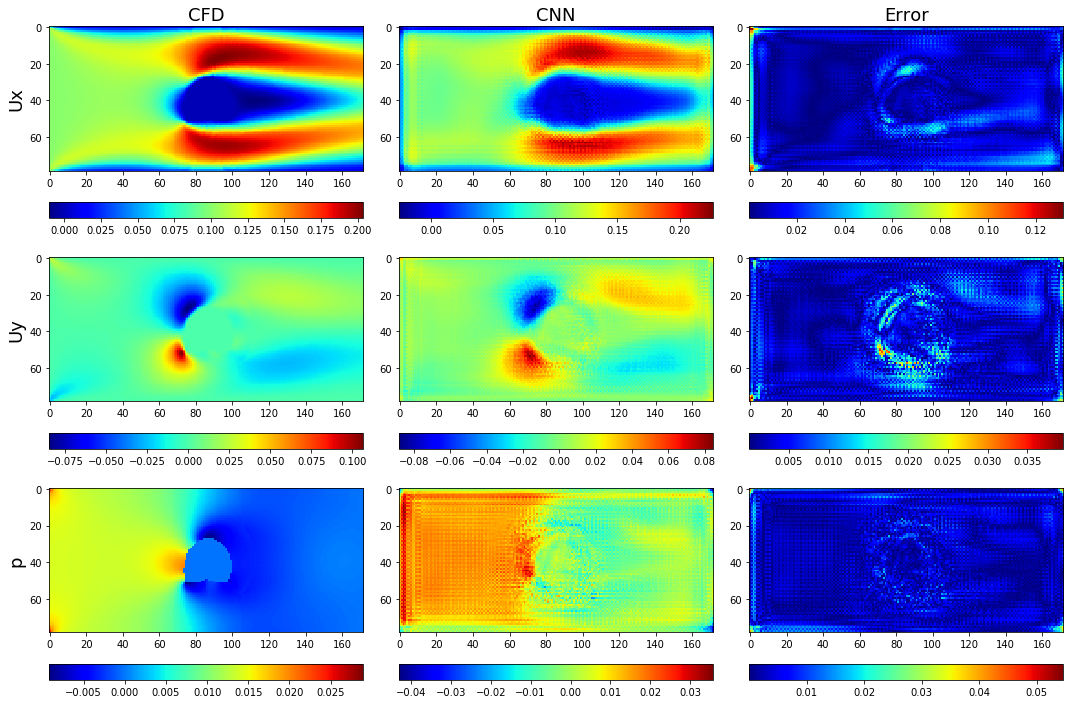

Epoch #11
	Train Loss = 131892.46801757812
	Train Total MSE = 6.403153419494629
	Train Ux MSE = 4.086404028392973
	Train Uy MSE = 0.6827482978502909
	Train p MSE = 1.6340009967486064
	Validation Loss = 36990.09127044678
	Validation Total MSE = 5.2429860124951
	Validation Ux MSE = 3.8152662990002484
	Validation Uy MSE = 0.6732331519514632
	Validation p MSE = 0.7544866018641779
Model saved!
Epoch #12
	Train Loss = 123422.81323242188
	Train Total MSE = 5.8389005433945425
	Train Ux MSE = 3.657712686629522
	Train Uy MSE = 0.6113394456250327
	Train p MSE = 1.569848344439552
	Validation Loss = 34001.647480010986
	Validation Total MSE = 4.78720798294437
	Validation Ux MSE = 3.470204699823188
	Validation Uy MSE = 0.620396008644137
	Validation p MSE = 0.6966073868802675
Model saved!
Epoch #13
	Train Loss = 119488.11254882812
	Train Total MSE = 5.555051531110491
	Train Ux MSE = 3.435670080639067
	Train Uy MSE = 0.5714587342171442
	Train p MSE = 1.5479227006435394
	Validation Loss = 33086.55628204

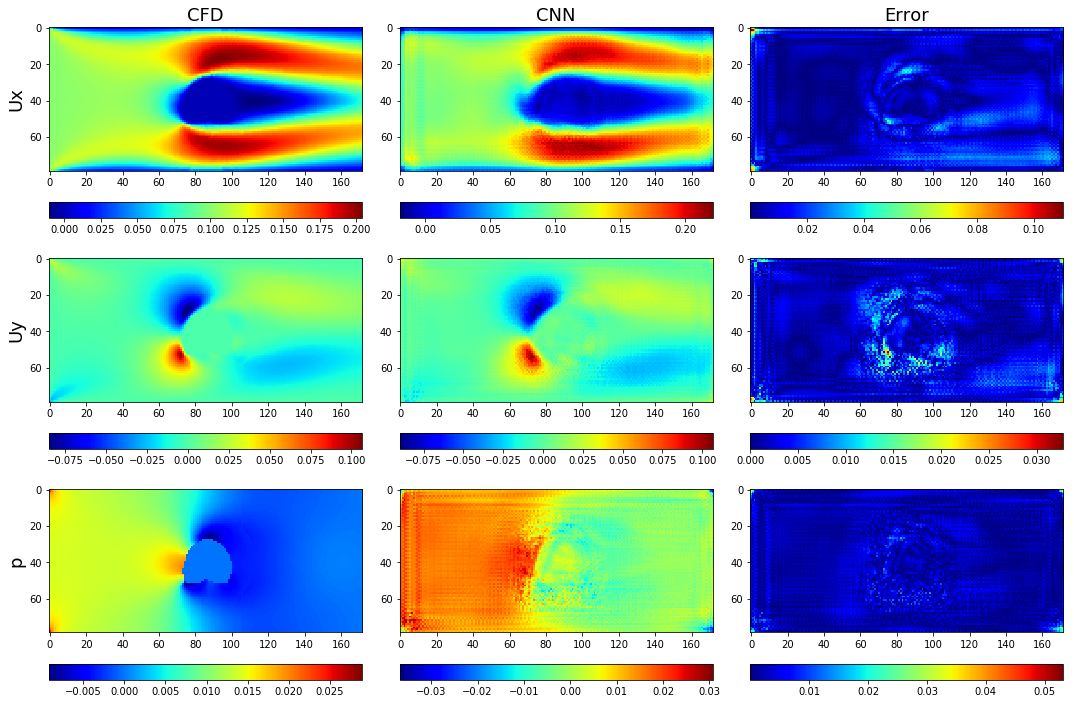

Epoch #21
	Train Loss = 99845.75744628906
	Train Total MSE = 4.154305906522842
	Train Ux MSE = 2.3384784289768765
	Train Uy MSE = 0.40068531816913966
	Train p MSE = 1.4151421437660854
	Validation Loss = 24446.546966552734
	Validation Total MSE = 3.228818440519815
	Validation Ux MSE = 2.264083868492021
	Validation Uy MSE = 0.40545630109557645
	Validation p MSE = 0.5592783282166122
Model saved!
Epoch #22
	Train Loss = 96794.97583007812
	Train Total MSE = 3.9848061062040783
	Train Ux MSE = 2.224687099456787
	Train Uy MSE = 0.3652866177615665
	Train p MSE = 1.3948324783926918
	Validation Loss = 24242.980688095093
	Validation Total MSE = 3.4130569333436167
	Validation Ux MSE = 2.48847098086532
	Validation Uy MSE = 0.3849182010315694
	Validation p MSE = 0.5396676458753517
Model saved!
Epoch #23
	Train Loss = 99943.57434082031
	Train Total MSE = 4.071493625640869
	Train Ux MSE = 2.252835137503488
	Train Uy MSE = 0.35982299631550196
	Train p MSE = 1.4588354996272497
	Validation Loss = 26442.42

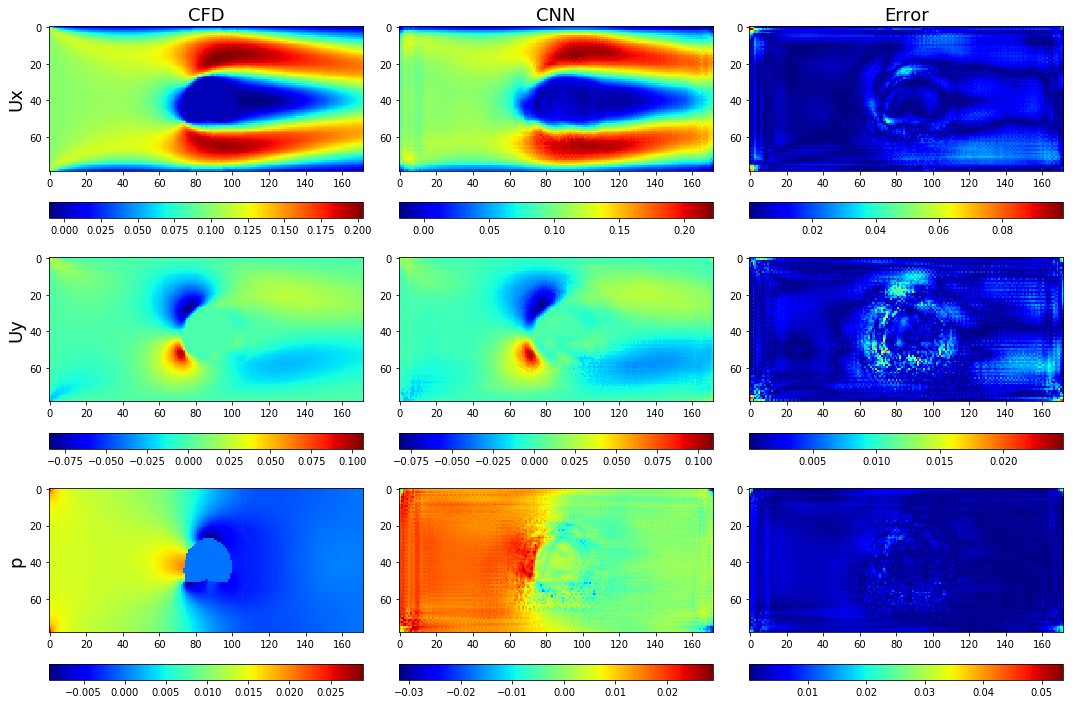

Epoch #31
	Train Loss = 92060.07165527344
	Train Total MSE = 3.5254814681552706
	Train Ux MSE = 1.8268496706372215
	Train Uy MSE = 0.3069149646021071
	Train p MSE = 1.3917167825358254
	Validation Loss = 23866.58644104004
	Validation Total MSE = 2.8393396992996904
	Validation Ux MSE = 1.8664881217850946
	Validation Uy MSE = 0.35537298111354604
	Validation p MSE = 0.6174787288099837
Epoch #32
	Train Loss = 90913.31335449219
	Train Total MSE = 3.4660773617880687
	Train Ux MSE = 1.7891534055982317
	Train Uy MSE = 0.2928130754402706
	Train p MSE = 1.38411084598019
	Validation Loss = 24551.230800628662
	Validation Total MSE = 2.9288504688797525
	Validation Ux MSE = 1.9261762873111712
	Validation Uy MSE = 0.37738894436598647
	Validation p MSE = 0.6252852934042062
Epoch #33
	Train Loss = 90383.900390625
	Train Total MSE = 3.42860962663378
	Train Ux MSE = 1.7576236043657576
	Train Uy MSE = 0.2972721202032907
	Train p MSE = 1.373714006018071
	Validation Loss = 20793.146215438843
	Validation Tota

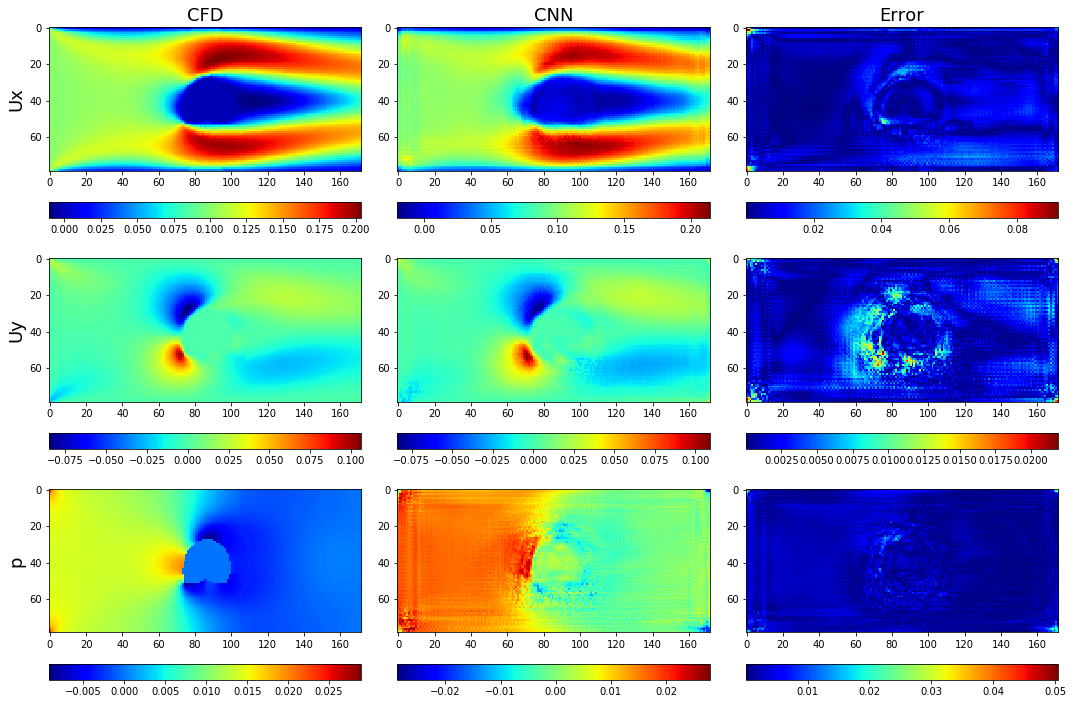

Epoch #41
	Train Loss = 88035.85034179688
	Train Total MSE = 3.2125110796519687
	Train Ux MSE = 1.5710922876993816
	Train Uy MSE = 0.27810631621451604
	Train p MSE = 1.3633124239387966
	Validation Loss = 19601.335411071777
	Validation Total MSE = 2.3531827802889076
	Validation Ux MSE = 1.5535318702974947
	Validation Uy MSE = 0.30560547935818305
	Validation p MSE = 0.49404546365812163
Model saved!
Epoch #42
	Train Loss = 87040.916015625
	Train Total MSE = 3.1865774506614324
	Train Ux MSE = 1.566782099860055
	Train Uy MSE = 0.2681810898440225
	Train p MSE = 1.3516141697764397
	Validation Loss = 21648.488161087036
	Validation Total MSE = 2.5180356370536514
	Validation Ux MSE = 1.627379450006056
	Validation Uy MSE = 0.3249626401747387
	Validation p MSE = 0.5656935432377983
Epoch #43
	Train Loss = 87353.02410888672
	Train Total MSE = 3.139048530941918
	Train Ux MSE = 1.501807885510581
	Train Uy MSE = 0.2845375105029061
	Train p MSE = 1.3527032332051367
	Validation Loss = 20260.73178100586
	

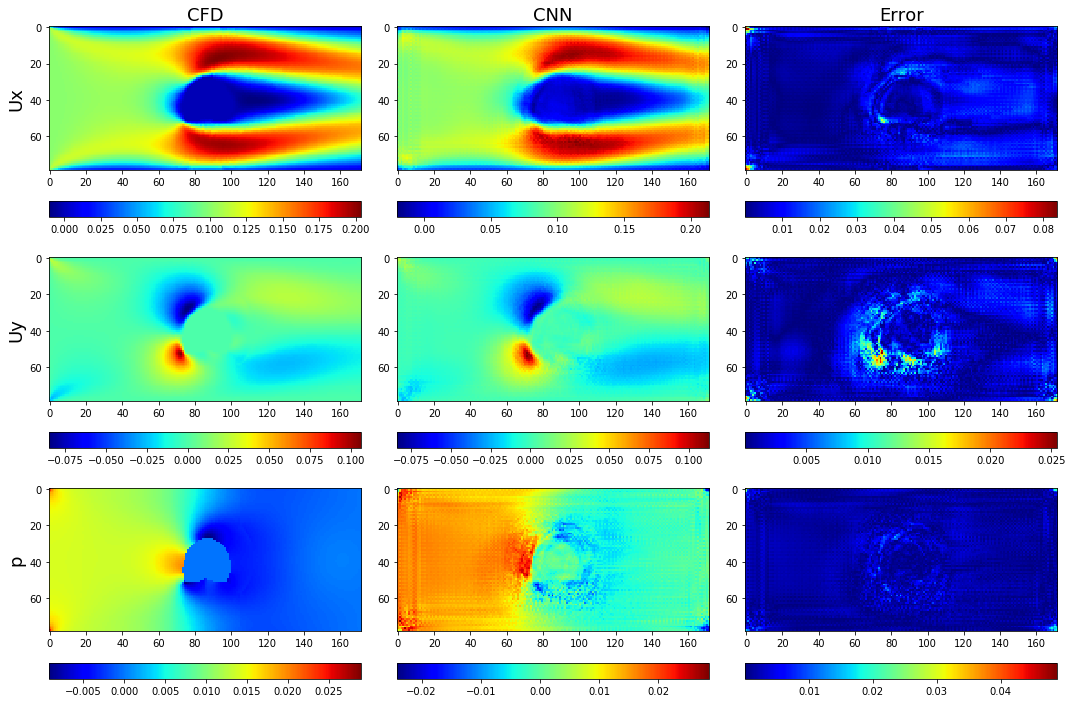

Epoch #51
	Train Loss = 85148.60925292969
	Train Total MSE = 3.0286607231412614
	Train Ux MSE = 1.4327481672877358
	Train Uy MSE = 0.26101142735708327
	Train p MSE = 1.3349011473002887
	Validation Loss = 21981.75737762451
	Validation Total MSE = 2.671826413345997
	Validation Ux MSE = 1.785120167534244
	Validation Uy MSE = 0.31996456773429593
	Validation p MSE = 0.5667417323713072
Epoch #52
	Train Loss = 88177.09924316406
	Train Total MSE = 3.0924770945594426
	Train Ux MSE = 1.4395957333700997
	Train Uy MSE = 0.24815707405408224
	Train p MSE = 1.4047242569781484
	Validation Loss = 25177.98960876465
	Validation Total MSE = 2.5743082576144527
	Validation Ux MSE = 1.5122783740911516
	Validation Uy MSE = 0.29661362321731544
	Validation p MSE = 0.7654162357628964
Epoch #53
	Train Loss = 88009.92614746094
	Train Total MSE = 3.0672079097656977
	Train Ux MSE = 1.4146665930747986
	Train Uy MSE = 0.2486348414704913
	Train p MSE = 1.403906567110902
	Validation Loss = 18469.239948272705
	Validation

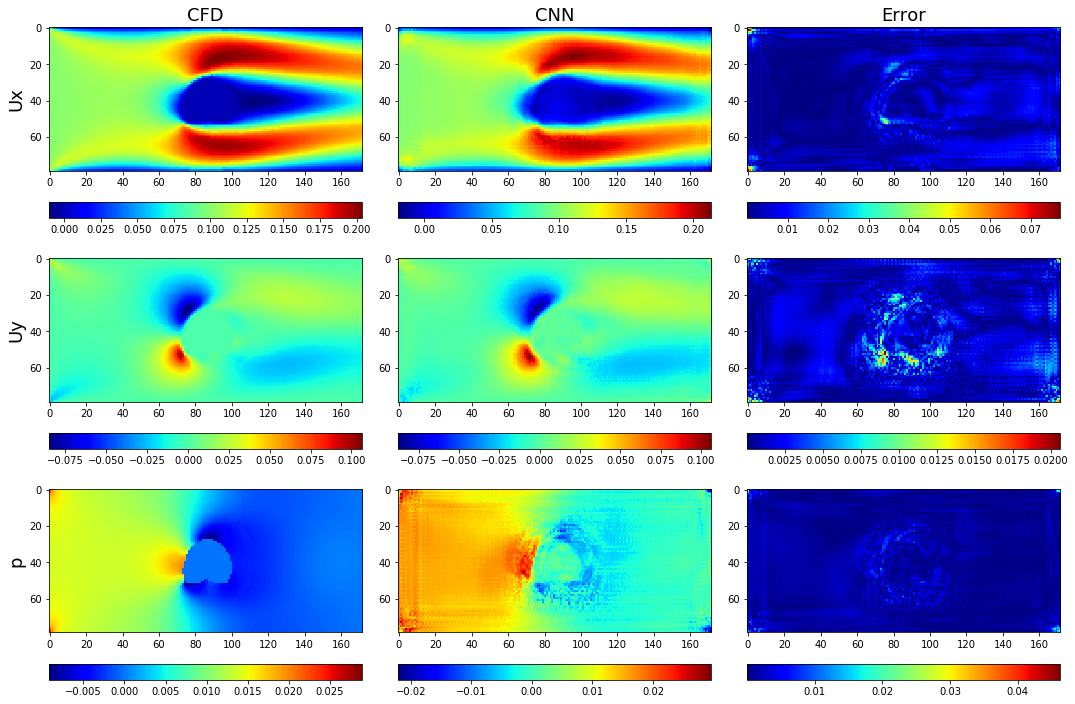

Epoch #61
	Train Loss = 82923.70825195312
	Train Total MSE = 2.795718190215883
	Train Ux MSE = 1.227195035843622
	Train Uy MSE = 0.2306069274033819
	Train p MSE = 1.3379161925542922
	Validation Loss = 20559.480766296387
	Validation Total MSE = 2.144520049276649
	Validation Ux MSE = 1.2748810659230374
	Validation Uy MSE = 0.2740117401193995
	Validation p MSE = 0.5956272266315341
Epoch #62
	Train Loss = 85218.85736083984
	Train Total MSE = 2.865549760205405
	Train Ux MSE = 1.2515464623769124
	Train Uy MSE = 0.24125136080242338
	Train p MSE = 1.372751805044356
	Validation Loss = 18431.994651794434
	Validation Total MSE = 2.025319719397073
	Validation Ux MSE = 1.2487860847921932
	Validation Uy MSE = 0.28699571311886335
	Validation p MSE = 0.48953799416140287
Epoch #63
	Train Loss = 83192.75732421875
	Train Total MSE = 2.7839976151784263
	Train Ux MSE = 1.2065307923725672
	Train Uy MSE = 0.2357929182194528
	Train p MSE = 1.3416739095534598
	Validation Loss = 18539.94757461548
	Validation To

KeyboardInterrupt: 

In [18]:
# Training model
train_model(model, loss_func, train_dataset, test_dataset, optimizer,
           epochs=10000, batch_size=32, device=device, after_epoch=after_epoch,
           m_mse_name="Total MSE",
           m_mse_on_batch=lambda scope: float(torch.sum((scope["output"] - scope["batch"][1]) ** 2)),
           m_mse_on_epoch=lambda scope: sum(scope["list"]) / len(scope["dataset"]),
           m_ux_name="Ux MSE",
           m_ux_on_batch=lambda scope: float(torch.sum((scope["output"][:,0,:,:] - scope["batch"][1][:,0,:,:]) ** 2)),
           m_ux_on_epoch=lambda scope: sum(scope["list"]) / len(scope["dataset"]),
           m_uy_name="Uy MSE",
           m_uy_on_batch=lambda scope: float(torch.sum((scope["output"][:,1,:,:] - scope["batch"][1][:,1,:,:]) ** 2)),
           m_uy_on_epoch=lambda scope: sum(scope["list"]) / len(scope["dataset"]),
           m_p_name="p MSE",
           m_p_on_batch=lambda scope: float(torch.sum((scope["output"][:,2,:,:] - scope["batch"][1][:,2,:,:]) ** 2)),
           m_p_on_epoch=lambda scope: sum(scope["list"]) / len(scope["dataset"]),
           )